In [1]:
import torch.nn as nn
import torch
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../modules/')
from modules.modules1D_cond import Unet1D, GaussianDiffusion1D
import matplotlib.pyplot as plt

/home/ukb12/miniconda3/envs/ml/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = 'cuda:2'

In [3]:
from MITBIH import mitbih_masked
import random
cond_ECG = mitbih_masked(filename = "../heartbeat/mitbih_train.csv", class_id = 0)
index_list = [i for i in range(len(cond_ECG))]
random.shuffle(index_list)
cond_data = torch.from_numpy(cond_ECG.cond_data[index_list][:10])
cond_data = cond_data.to(device).to(torch.float)

Data shape of Non-Ectopic Beats instances = (72471, 1, 128)


In [4]:
cond_data.shape

torch.Size([10, 1, 128])

In [6]:
model = Unet1D(
    dim = 64,
    self_condition = True,
    dim_mults = (1, 2, 4, 8),
    channels = 1)

ckpt = torch.load("../checkpoint/DDPM1D_Selfcondtional_maskedCond/checkpoint.pt")
model.load_state_dict(ckpt['model_state_dict'])
model = model.to(device)
# seq_length must be able to divided by dim_mults
diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 1000,
    objective = 'pred_v').to(device)

In [7]:
sampled_data = diffusion.sample(batch_size = 10, input_cond = cond_data)

sampling loop time step: 100%|██████████| 1000/1000 [00:20<00:00, 49.52it/s]


In [8]:
print(sampled_data.shape) # (sample_size, 3, 150)
sampled_data= sampled_data.to('cpu').detach().numpy()

torch.Size([10, 1, 128])


In [9]:
def plot_signals_cls_free(signals, title):
    fig, axs = plt.subplots(2, 5, figsize=(20,5))
    for i in range(2):
        for j in range(5):
            axs[i, j].plot(signals[i*5+j][0][:])
    fig.suptitle(title)
    fig.show()

In [10]:
cond_data_cpu = cond_data.to("cpu").to(torch.float)

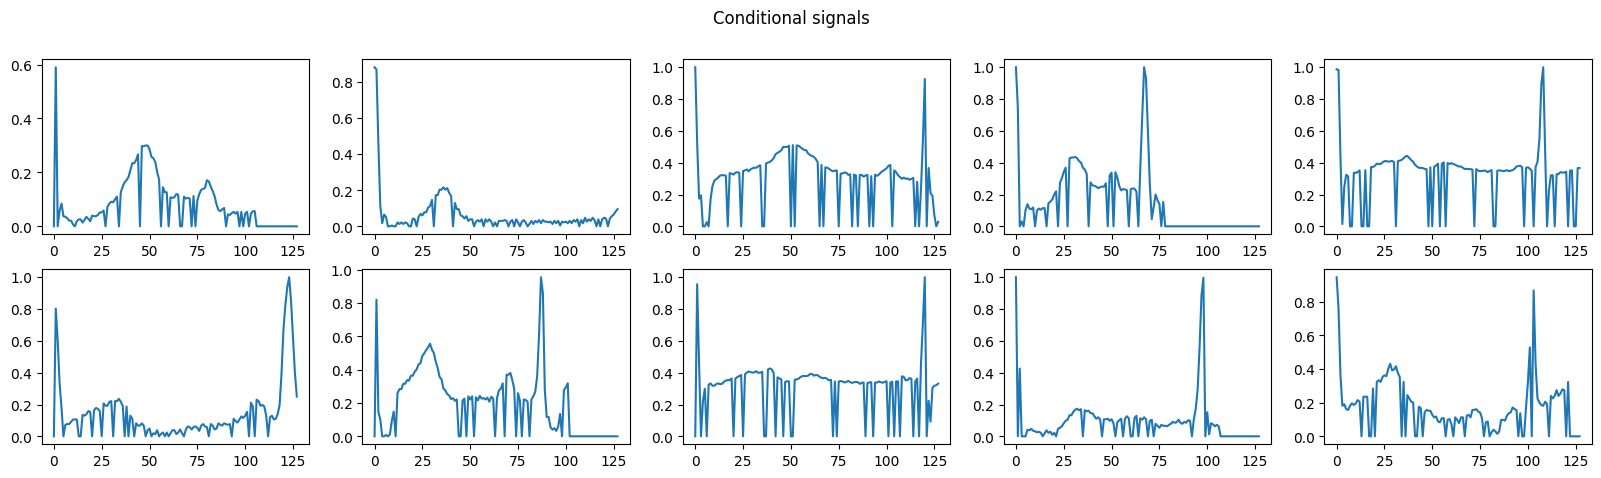

In [11]:
plot_signals_cls_free(cond_data_cpu, 'Conditional signals')

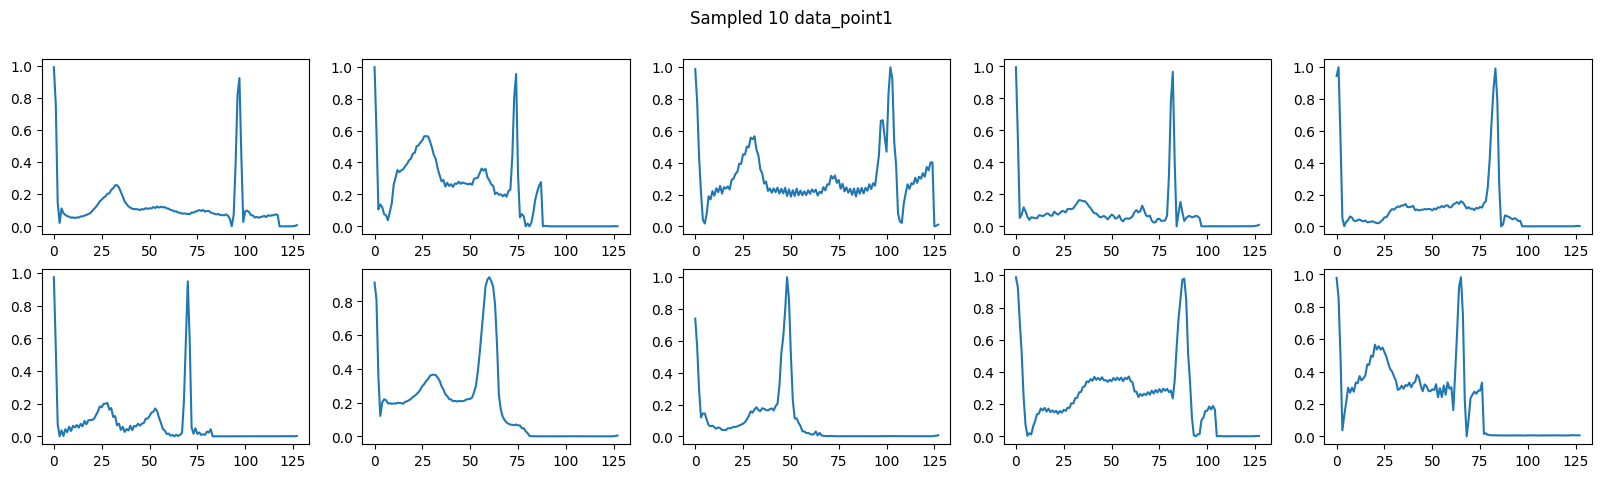

In [13]:
plot_signals_cls_free(sampled_data, 'Sampled 10 data_point1')